In [6]:
import os
import sys
import time
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from tqdm.notebook import tqdm
from pathlib import Path
import importlib.util
from gpt4all import GPT4All
from langchain_huggingface import HuggingFacePipeline
from transformers import AutoModelForCausalLM, AutoTokenizer
from langchain_community.llms import Ollama, GPT4All as LC_GPT4All

In [7]:
spec = importlib.util.spec_from_file_location("pipeline_module", "pipeline_file.py")
pipeline_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(pipeline_module)
DocumentationQA = pipeline_module.DocumentationQA
AnswerGenerator = pipeline_module.AnswerGenerator

# Функция для запроса к внешней LLM для оценки
def evaluate_with_external_llm(question, context, answer, eval_metric):
    """
    Оценивает ответ с помощью внешней LLM по указанной метрике
    
    Параметры:
    - question: вопрос пользователя
    - context: контекст, на основе которого был сгенерирован ответ
    - answer: сгенерированный ответ, который нужно оценить
    - eval_metric: метрика оценки ('faithfulness', 'answer_relevancy', 'hallucination')
    
    Возвращает:
    - score: числовая оценка по шкале 1-10
    - explanation: объяснение оценки
    """
    metric_descriptions = {
        'faithfulness': "насколько ответ соответствует и основан на предоставленном контексте, верно ли передает информацию",
        'answer_relevancy': "насколько ответ релевантен заданному вопросу, отвечает ли точно на поставленный вопрос",
        'hallucination': "содержит ли ответ информацию, которой нет в контексте, или выдумывает факты (10 - нет галлюцинаций, 1 - много галлюцинаций)"
    }
    
    prompt = f"""
    Ты должен оценить качество ответа, сгенерированного языковой моделью, по шкале от 1 до 10.

    Вопрос: {question}

    Контекст (на основе которого сгенерирован ответ):
    {context}

    Ответ модели:
    {answer}

    Оцени **{eval_metric}** ответа ({metric_descriptions[eval_metric]}) по шкале от 1 до 10, где:
    - 10: превосходное качество
    - 1: очень низкое качество

    Дай оценку только в числовом виде от 1 до 10, без дополнительных комментариев и объяснений.
    """
    
    request_json = {
        "message": prompt,
        "api_key": 'chad-ea4e58bc0ac4441ca91e1188ca33120cpsekgbal'
    }
    url = "https://ask.chadgpt.ru/api/public/gpt-4o-mini"
    
    try:
        response = requests.post(url, json=request_json)
        response.raise_for_status()
        
        result = response.json()
        response_text = result.get('text', '')
        
        # Извлекаем оценку из ответа
        score_line = [line for line in response_text.split('\n') if line.startswith('Оценка:')]
        if score_line:
            try:
                score = float(score_line[0].replace('Оценка:', '').strip())
            except:
                score = None
        else:
            score = None
        
        # Извлекаем объяснение
        explanation_lines = response_text.split('Объяснение:')
        explanation = explanation_lines[1].strip() if len(explanation_lines) > 1 else response_text
        
        return {'score': score}
    
    except Exception as e:
        print(f"Ошибка при оценке: {str(e)}")
        return {'score': None, 'explanation': f"Ошибка: {str(e)}"}

In [8]:
# Класс для тестирования модели GPT4All
class GPT4AllTester:
    def __init__(self, model_path):
        self.model_path = model_path
        self.model_name = os.path.basename(model_path)
        self.model = None
    
    def initialize(self):
        if self.model is None:
            try:
                print(f"Инициализация GPT4All модели: {self.model_name}")
                self.model = GPT4All(self.model_path)
                return True
            except Exception as e:
                print(f"Ошибка при инициализации GPT4All модели: {str(e)}")
                return False
        return True
    
    def generate(self, prompt, max_tokens=500, temp=0.7, top_k=40, top_p=0.4):
        if not self.initialize():
            return f"Не удалось инициализировать модель {self.model_name}"
        
        try:
            response = self.model.generate(
                prompt,
                max_tokens=max_tokens,
                temp=temp,
                top_k=top_k,
                top_p=top_p
            )
            return response
        except Exception as e:
            return f"Ошибка генерации: {str(e)}"

# Класс для тестирования модели HuggingFace
class HuggingFaceTester:
    def __init__(self, model_id):
        self.model_id = model_id
        self.pipeline = None
        self.model_name = model_id.split('/')[-1]
    
    def initialize(self):
        if self.pipeline is None:
            try:
                print(f"Инициализация HuggingFace модели: {self.model_id}")
                tokenizer = AutoTokenizer.from_pretrained(self.model_id)
                model = AutoModelForCausalLM.from_pretrained(
                    self.model_id, 
                    device_map="auto", 
                    load_in_8bit=True
                )
                
                pipe = pipeline(
                    "text-generation",
                    model=model,
                    tokenizer=tokenizer,
                    max_new_tokens=500
                )
                
                self.pipeline = HuggingFacePipeline(pipeline=pipe)
                return True
            except Exception as e:
                print(f"Ошибка при инициализации HuggingFace модели: {str(e)}")
                return False
        return True
    
    def generate(self, prompt, max_tokens=500, temp=0.7, top_k=40, top_p=0.4):
        if not self.initialize():
            return f"Не удалось инициализировать модель {self.model_id}"
        
        try:
            response = self.pipeline.invoke(
                prompt,
                {"max_tokens": max_tokens, "temperature": temp, "top_k": top_k, "top_p": top_p}
            )
            return response
        except Exception as e:
            return f"Ошибка генерации: {str(e)}"

# Класс для тестирования модели Ollama
class OllamaTester:
    def __init__(self, model_name):
        self.model_name = model_name
        self.llm = None
    
    def initialize(self):
        if self.llm is None:
            try:
                print(f"Инициализация Ollama модели: {self.model_name}")
                self.llm = Ollama(model=self.model_name)
                return True
            except Exception as e:
                print(f"Ошибка при инициализации Ollama модели: {str(e)}")
                return False
        return True
    
    def generate(self, prompt, max_tokens=500, temp=0.7, top_k=40, top_p=0.4):
        if not self.initialize():
            return f"Не удалось инициализировать модель {self.model_name}"
        
        try:
            response = self.llm.invoke(
                prompt,
                {"max_tokens": max_tokens, "temperature": temp, "top_k": top_k, "top_p": top_p}
            )
            return response
        except Exception as e:
            return f"Ошибка генерации: {str(e)}"

In [9]:
# Функция для создания модифицированного класса AnswerGenerator
def create_custom_generator(llm_tester, params):
    class CustomAnswerGenerator(AnswerGenerator):
        def __init__(self, top_k=3):
            super().__init__(top_k)
            self.model = None
            self.llm_tester = llm_tester
            self.params = params
        
        def initialize_model(self):
            # Ничего не делаем здесь, так как модель инициализируется в llm_tester
            pass
        
        def generate_answer(self, question, context_list):
            context_texts = "\n\n".join([
                f"Fragment {i+1} (from {doc.get('name', 'unknown')}, similarity: {doc.get('rerank_score', doc.get('score', 0)):.3f}):\n{doc['text']}"
                for i, doc in enumerate(context_list[:self.top_k])
            ])
            
            prompt = f"""Based on the following context, please answer the question accurately and concisely.
                        Question: {question}
                        Context:
                        {context_texts}
                        Answer: """
            
            return self.llm_tester.generate(
                prompt,
                max_tokens=self.params['max_tokens'],
                temp=self.params['temperature'],
                top_k=self.params['top_k'],
                top_p=self.params['top_p']
            )
    
    return CustomAnswerGenerator

In [10]:
# Подготовка тестовых вопросов
df = pd.read_csv('qdrant_documentation_dataset.csv')

test_questions = list(df.question.unique())

In [15]:
# Подготовка моделей для тестирования
models_to_test = [
    {
        "type": "gpt4all",
        "name": "deepseek-coder-1.3b-instruct.Q4_K_M.gguf",
        "description": "GPT4All deepseek"
    },
    {
        "type": "gpt4all",
        "name": "qwen2-1_5b-instruct-q4_0.gguf",
        "description": "GPT4All qwen2"
    }
]


parameter_sets = [
    {
        "name": "temp_0",
        "max_tokens": 500,
        "temperature": 0,
        "top_k": 40,
        "top_p": 0.0
    },
    {
        "name": "balanced",
        "max_tokens": 500,
        "temperature": 0.3,
        "top_k": 40,
        "top_p": 0.3
    }
]


In [16]:
# Основная функция запуска тестирования
def run_evaluation():
    # Инициализируем базу знаний один раз
    print("Initializing knowledge base...")
    documentation_qa = DocumentationQA()
    documentation_qa.initialize_database()
    
    results = []
    
    # Проходим по всем моделям
    for model_config in models_to_test:
        model_type = model_config["type"]
        model_name = model_config["name"]
        description = model_config["description"]
        
        print(f"\n{'='*50}")
        print(f"Testing model: {description}")
        print(f"{'='*50}")
        
        # Инициализируем модель в зависимости от типа
        if model_type == "gpt4all":
            tester = GPT4AllTester(model_name)
        elif model_type == "huggingface":
            tester = HuggingFaceTester(model_name)
        elif model_type == "ollama":
            tester = OllamaTester(model_name)
        else:
            print(f"Неизвестный тип модели: {model_type}")
            continue
            
        # Проверяем, можем ли инициализировать модель
        if not tester.initialize():
            print(f"Пропускаем модель {description} из-за ошибки инициализации")
            continue
        
        # Проходим по всем наборам параметров
        for params in parameter_sets:
            param_name = params["name"]
            print(f"\nTesting with {param_name} parameters:")
            
            # Создаем кастомный генератор ответов
            custom_generator = create_custom_generator(tester, params)
            
            # Заменяем генератор ответов в нашем пайплайне
            documentation_qa.answer_generator = custom_generator(top_k=3)
            
            # Проходим по всем тестовым вопросам
            for question in tqdm(test_questions, desc=f"{description} - {param_name}"):
                # Поиск похожих параграфов
                similar_paragraphs = documentation_qa.search_similar_paragraphs(question, top_k=3)
                
                # Формируем контекст (такой же, как будет использоваться для генерации)
                context_texts = "\n\n".join([
                    f"Fragment {i+1} (from {doc.get('name', 'unknown')}, similarity: {doc.get('rerank_score', doc.get('score', 0)):.3f}):\n{doc['text']}"
                    for i, doc in enumerate(similar_paragraphs)
                ])
                
                # Генерируем ответ
                try:
                    start_time = time.time()
                    answer = documentation_qa.answer_generator.generate_answer(question, similar_paragraphs)
                    generation_time = time.time() - start_time
                except Exception as e:
                    print(f"Ошибка при генерации ответа: {str(e)}")
                    continue
                
                # Сохраняем результаты
                result = {
                    "model_type": model_type,
                    "model_name": model_name,
                    "description": description,
                    "parameters": param_name,
                    "question": question,
                    "context": context_texts,
                    "answer": answer,
                    "generation_time": generation_time
                }
                
                results.append(result)
                
                # Сохраняем промежуточные результаты
                df = pd.DataFrame(results)
                df.to_csv('rag_model_generation_results_seria2.csv', index=False)
                
                # Делаем небольшую паузу между запросами
                time.sleep(1)
    
    return pd.DataFrame(results)

In [17]:
# Анализ результатов
def analyze_results(results_df):
    # Создаем сводную таблицу со средним временем генерации
    summary = results_df.groupby(['description', 'parameters']).agg({
        'generation_time': 'mean'
    }).reset_index()
    
    # Сортируем по времени генерации
    summary = summary.sort_values('generation_time')
    
    print("Сводные результаты (сортировка по времени генерации):")
    print(summary)
    
    # Визуализация времени генерации
    plt.figure(figsize=(12, 6))
    sns.barplot(x='description', y='generation_time', hue='parameters', data=results_df, palette='rocket')
    plt.xticks(rotation=45, ha='right')
    plt.title('Среднее время генерации ответа (секунды)')
    plt.tight_layout()
    plt.savefig('generation_time.png')
    
    return summary

Запускаем процесс оценки моделей (это может занять много времени)...
Initializing knowledge base...

Testing model: GPT4All deepseek
Инициализация GPT4All модели: deepseek-coder-1.3b-instruct.Q4_K_M.gguf

Testing with temp_0 parameters:


GPT4All deepseek - temp_0:   0%|          | 0/327 [00:00<?, ?it/s]


Testing with balanced parameters:


GPT4All deepseek - balanced:   0%|          | 0/327 [00:00<?, ?it/s]


Testing model: GPT4All qwen2
Инициализация GPT4All модели: qwen2-1_5b-instruct-q4_0.gguf

Testing with temp_0 parameters:


GPT4All qwen2 - temp_0:   0%|          | 0/327 [00:00<?, ?it/s]


Testing with balanced parameters:


GPT4All qwen2 - balanced:   0%|          | 0/327 [00:00<?, ?it/s]

Сводные результаты (сортировка по времени генерации):
        description parameters  generation_time
0  GPT4All deepseek   balanced        24.813316
2     GPT4All qwen2   balanced        33.421064
3     GPT4All qwen2     temp_0        38.613514
1  GPT4All deepseek     temp_0        46.905873


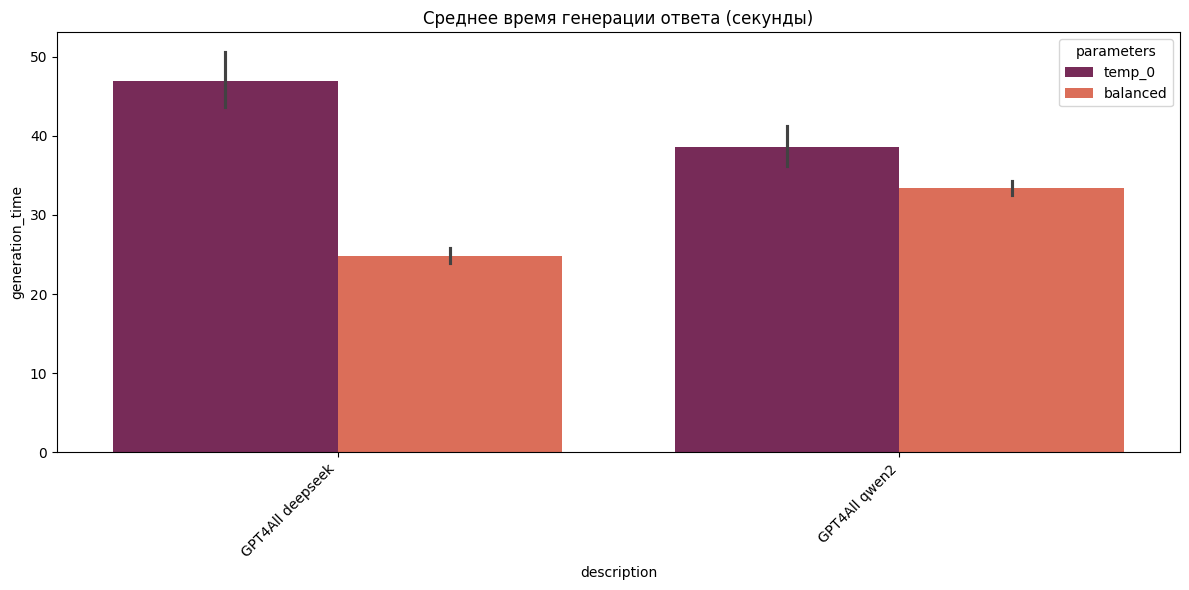

In [18]:
# Запуск всего процесса оценки и анализа
if __name__ == "__main__":
    print("Запускаем процесс оценки моделей (это может занять много времени)...")
    results_df = run_evaluation()
    
    # Анализируем результаты
    summary = analyze_results(results_df)